In [1]:
from __future__ import division
import pyomo.environ as pyomo
import pyomo.opt as opt

import pandas as pd

import matplotlib.pyplot as plt

# Welcome to the ESA programming exercise on basic dispatch LP models

## 1. Prepare the input data for the LP model

In [2]:
T = [0,1,2,3,4,5,6,7,8,9] # set of timesteps
G = ['CCGT','GT','Coal','Lignite','Nuclear','Wind','PV'] # generator technologies
V = ['diesel','gasoline','gas','electricity'] # passenger car engine technologies

In [3]:
# tax for CO2 emissions [€/t CO2]
CO2_TAX = 0

In [4]:
# max CO2 emissions allowed (for elecitricity generation and passenger car mobility) [Mio. t CO2]
MAX_CO2_limit = False
MAX_CO2_value = 25

In [5]:
# decide whether to phase out of nuclear energy
nuclear_phase_out = False

In [6]:
# Gas price increase [1]
GAS_PR_LVL = 1.0

In [7]:
# constant length of timesteps
LENGTH = 876

In [8]:
# peak load [MW]
PEAK_LOAD = 79487

In [9]:
# number of passenger cars [1]
PAS_CARS = 48*1e6

In [10]:
# convention:   tech_data[(g,'invest')] = investment costs of technology g [€/kW_el]
#               tech_data[(g,'eta_el')] = efficiency factor of technology g [1]
#               tech_data[(g,'fuel price')]= fuel price of technology g [€/MWh_thermal]
#               tech_data[(g,'other variable costs')] = other variable costs of technology g [€/MWh_el]
#               tech_data[(g,'emissions')] = emission factor of technology g [kg CO2/MWh_thermal]

tech_data_g = {('CCGT','invest'):    500,('CCGT','RBF'):    9.8,('CCGT','eta_el'):   0.55,('CCGT','fuel price'):   28.00*(GAS_PR_LVL),('CCGT','other variable costs'):    5.23,('CCGT','emissions'):   204.8, 
               ('GT','invest'):      450,('GT','RBF'):      9.8,('GT','eta_el'):     0.37,('GT','fuel price'):     28.00*(GAS_PR_LVL),('GT','other variable costs'):      3.60,('GT','emissions'):     204.8, 
               ('Coal','invest'):   1300,('Coal','RBF'):   11.3,('Coal','eta_el'):   0.42,('Coal','fuel price'):   10.47,             ('Coal','other variable costs'):    9.70,('Coal','emissions'):   342.0,
               ('Lignite','invest'):1400,('Lignite','RBF'):11.3,('Lignite','eta_el'):0.39,('Lignite','fuel price'): 7.50,             ('Lignite','other variable costs'):13.44,('Lignite','emissions'):400.0, 
               ('Nuclear','invest'):3000,('Nuclear','RBF'):11.9,('Nuclear','eta_el'):0.35,('Nuclear','fuel price'): 3.47,             ('Nuclear','other variable costs'): 7.46,('Nuclear','emissions'):  0.0, 
               ('Wind','invest'):   1200,('Wind','RBF'):    9.8,('Wind','eta_el'):    1.0,('Wind','fuel price'):     0.0,             ('Wind','other variable costs'):    3.32,('Wind','emissions'):  0.0, 
               ('PV','invest'):     900,('PV','RBF'):      9.8,('PV','eta_el'):      1.0,('PV','fuel price'):        0.0,             ('PV','other variable costs'):      2.55,('PV','emissions'):  0.0}

In [11]:
# convention:   efficiency_data_v[(v,'invest')] = investment costs of technology v [€/unit]
#               efficiency_data_v[(v,'eta_final_to_service')] = required end energy for providing a unit of mobility service of technology v [kWh/100km]
#               efficiency_data_v[(v,'fuel price')] = fuel price of technology v (for electricity without procurement and supply) [€/(MWh_th or el)]
#               efficiency_data_v[(v,'other variable costs')] = other variable costs of technology v [€/year]
#               efficiency_data_v[(v,'emissions')] = emission factor of technology g [kg CO2/MWh_thermal]

vehicle_data_v = {('diesel', 'invest'): 25600,      ('diesel', 'RBF'): 9.4,      ('diesel', 'eta_final_to_service'): 70.17,          ('diesel', 'fuel price'): 122.4,      ('diesel', 'other variable costs'): 409.47,      ('diesel','emissions'): 241.84, 
                  ('gasoline', 'invest'): 23000,    ('gasoline', 'RBF'): 9.4,    ('gasoline', 'eta_final_to_service'): 68.83,        ('gasoline', 'fuel price'): 168.5,    ('gasoline', 'other variable costs'): 368.38,    ('gasoline','emissions'): 297.75, 
                  ('gas', 'invest'): 24600,         ('gas', 'RBF'): 9.4,         ('gas', 'eta_final_to_service'): 60.94*(GAS_PR_LVL),('gas', 'fuel price'): 91.7,          ('gas', 'other variable costs'): 394.14,         ('gas','emissions'): 135.83, 
                  ('electricity', 'invest'): 33900, ('electricity', 'RBF'): 6.7, ('electricity', 'eta_final_to_service'): 20.19,     ('electricity', 'fuel price'): 242.0, ('electricity', 'other variable costs'): 305.13, ('electricity','emissions'): 0.0}

In [12]:
# convention: load_t[t] = constant load during timestep t [MW]
load_t = [73409,69648,66632,63454,59526,55367,51970,49045,46030,41466]

In [13]:
# mobility demand: vehicle_pas_car_t[t] = vehicle km traveled on average by a passenger car during the full length of timestep t [km]
vehicle_pas_car_t = [1199,1351,1376,1354,1404,1546,1512,1408,1337,1239]

In [14]:
availability_g_t = {
    'CCGT': [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
    'GT': [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
    'Coal': [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
    'Lignite': [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
    'Nuclear': [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
    'Wind': [0.2696,0.2419,0.2159,0.1930,0.2140,0.2086,0.2208,0.2429,0.2965,0.4614],
    'PV': [0.0267,0.0579,0.1197,0.1767,0.1947,0.1951,0.1558,0.0947,0.0383,0.0194]
}

## 2. Build the LP model

In [15]:
model = pyomo.ConcreteModel()

### 2.1 Define Sets

In [16]:
model.T = pyomo.Set(initialize=T)
model.G = pyomo.Set(initialize=G)
model.V = pyomo.Set(initialize=V)

### 2.2 Define Variables

In [17]:
model.x_g_t = pyomo.Var(model.G, model.T, domain=pyomo.NonNegativeReals)    # dispatched power of technology g during hour t [MW]
model.y_g = pyomo.Var(model.G, domain=pyomo.NonNegativeReals)               # installed capacity per technology g [MW]
model.y_v = pyomo.Var(model.V, domain=pyomo.NonNegativeReals)               # installed capacity per technology v [MW]

### 2.3 Define Constraints

In [18]:
# cover electricity demand
def define_electricity_demand_restriction(model, t):
    return sum(model.x_g_t[g, t] for g in model.G) == load_t[t] + \
               model.y_v["electricity"] * vehicle_pas_car_t[t] * vehicle_data_v[('electricity', 'eta_final_to_service')] / 100000 / LENGTH
model.electricity_demand_restriction = pyomo.Constraint(model.T, rule=define_electricity_demand_restriction)

In [19]:
# cover mobility demand
def define_mobility_demand_restriction(model):
    return sum(model.y_v[v] for v in model.V) == PAS_CARS
model.mobility_demand_restriction = pyomo.Constraint(rule=define_mobility_demand_restriction)

In [20]:
# cover peak load
def define_peak_load_restriction(model):
    return sum(model.y_g[g] for g in model.G) >= PEAK_LOAD
model.peak_load_restriction = pyomo.Constraint(rule=define_peak_load_restriction)

In [21]:
# capacity restriciton and variable connection
def define_capacity_restriciton(model, g, t):
    return model.x_g_t[g,t] <= availability_g_t[g][t] * model.y_g[g]
model.capacity_restriciton = pyomo.Constraint(model.G, model.T, rule=define_capacity_restriciton)

In [22]:
# no use of nuclear power plants
if nuclear_phase_out:
    def define_nuclear_restriciton(model):
        return model.y_g['Nuclear'] == 0
    model.nuclear_restriciton = pyomo.Constraint(rule=define_nuclear_restriciton)

In [23]:
# no use of nuclear power plants
if MAX_CO2_limit:
    def define_co2_limit(model):
        return sum(model.x_g_t[g, t] * LENGTH * tech_data_g[(g,'emissions')] / tech_data_g[(g,'eta_el')] for g in model.G for t in model.T) \
               + sum(model.y_v[v] * vehicle_data_v[(v,'emissions')] * vehicle_data_v[(v,'eta_final_to_service')] / 100000 * vehicle_pas_car_t[t] for v in model.V for t in model.T) \
               <= MAX_CO2_value * 10**9
    model.co2_limit = pyomo.Constraint(rule=define_co2_limit)

### 2.4 Define Objective Function

In [24]:
# define objective function (i.e. dispatch costs)
def define_objective_function(model):
    return sum(
                tech_data_g[(g,'invest')] * 1000 / tech_data_g[(g,'RBF')] * \
                model.y_g[g] 
                for g in model.G
              ) + \
            sum(
                (vehicle_data_v[(v,'invest')] / vehicle_data_v[(v,'RBF')] + vehicle_data_v[(v,'other variable costs')]) * \
                model.y_v[v] 
                for v in model.V
              ) + \
           sum(
                (
                    (tech_data_g[(g,'fuel price')] + tech_data_g[(g,'emissions')] * (CO2_TAX/1000)) / 
                    tech_data_g[(g,'eta_el')] + \
                    tech_data_g[(g,'other variable costs')] \
                ) * \
                model.x_g_t[g,t] * LENGTH 
                for g in model.G for t in model.T
              ) + \
           sum(
                (
                    (vehicle_data_v[(v,'fuel price')] + vehicle_data_v[(v,'emissions')] * (CO2_TAX/1000)) * \
                     vehicle_data_v[(v,'eta_final_to_service')] / 100000 \
                     * vehicle_pas_car_t[t] \
                ) * \
                model.y_v[v]
                for v in model.V for t in model.T
              )
model.Obj = pyomo.Objective(rule=define_objective_function, sense=pyomo.minimize)

### 2.5 Write LP to File

In [25]:
model.write('output/sector_coupling/09_tesa_uebung_LP2_sektorenkopplung_loesung.lp', io_options={'symbolic_solver_labels':True})

('output/sector_coupling/09_tesa_uebung_LP2_sektorenkopplung_loesung.lp',
 1712071584032)

### 2.6 Initialize the storage of dual variables of constraints

In [26]:
model.dual = pyomo.Suffix(direction=pyomo.Suffix.IMPORT)

## 3. Solve the LP model

In [27]:
optimizer = opt.SolverFactory('glpk')
solved_model = optimizer.solve(model, tee=True)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\jpr\AppData\Local\Temp\tmpw8wj5f78.glpk.raw --wglp C:\Users\jpr\AppData\Local\Temp\tmpsyppdyl4.glpk.glp
 --cpxlp C:\Users\jpr\AppData\Local\Temp\tmpi4rk7yv_.pyomo.lp
Reading problem data from 'C:\Users\jpr\AppData\Local\Temp\tmpi4rk7yv_.pyomo.lp'...
83 rows, 82 columns, 232 non-zeros
651 lines were read
Writing problem data to 'C:\Users\jpr\AppData\Local\Temp\tmpsyppdyl4.glpk.glp'...
564 lines were written
GLPK Simplex Optimizer, v4.65
83 rows, 82 columns, 232 non-zeros
Preprocessing...
82 rows, 80 columns, 230 non-zeros
Scaling...
 A: min|aij| =  2.763e-04  max|aij| =  1.000e+00  ratio =  3.619e+03
GM: min|aij| =  5.931e-01  max|aij| =  1.686e+00  ratio =  2.843e+00
EQ: min|aij| =  3.545e-01  max|aij| =  1.000e+00  ratio =  2.820e+00
Constructing initial basis...
Size of triangular part is 82
      0: obj =   2.154456393e+11 inf =   1.018e+07 (11)
     14: obj =   2.560678734e+11 inf =   0.

## 4. Get the results and statistics of the solved LP model

### 4.1 Print optimal objective value

In [28]:
print("Optimal value: %.2f Bio. €" % (round(model.Obj.expr()/1e9,2)))

Optimal value: 206.61 Bio. €


### 4.2 Print optimal invest for power plant technologies

In [29]:
EPS = 1e-6

for g in G:
    if pyomo.value(model.y_g[g]) > EPS: 
        print('Install %i MW of power plant technology %s' % (pyomo.value(model.y_g[g]),g))

Install 9317 MW of power plant technology CCGT
Install 8216 MW of power plant technology Coal
Install 16004 MW of power plant technology Lignite
Install 37626 MW of power plant technology Nuclear
Install 8321 MW of power plant technology Wind


### 4.2 Print optimal invest for passenger car technologies

In [30]:
EPS = 1e-6

for v in V:
    if pyomo.value(model.y_v[v]) > EPS: 
        print('Install %i units of passenger car technology %s' % (pyomo.value(model.y_v[v]),v))

Install 48000000 units of passenger car technology gas


### 4.3 Print optimal dispatch path

In [31]:
for g in G:
    for t in T:
        if pyomo.value(model.x_g_t[g,t]) > EPS:
            print("Dispatch %i TWh of technology %s in timestep %s" % (pyomo.value(model.x_g_t[g,t])*LENGTH/1e6,g,t))        

Dispatch 8 TWh of technology CCGT in timestep 0
Dispatch 5 TWh of technology CCGT in timestep 1
Dispatch 2 TWh of technology CCGT in timestep 2
Dispatch 7 TWh of technology Coal in timestep 0
Dispatch 7 TWh of technology Coal in timestep 1
Dispatch 7 TWh of technology Coal in timestep 2
Dispatch 7 TWh of technology Coal in timestep 3
Dispatch 3 TWh of technology Coal in timestep 4
Dispatch 14 TWh of technology Lignite in timestep 0
Dispatch 14 TWh of technology Lignite in timestep 1
Dispatch 14 TWh of technology Lignite in timestep 2
Dispatch 14 TWh of technology Lignite in timestep 3
Dispatch 14 TWh of technology Lignite in timestep 4
Dispatch 14 TWh of technology Lignite in timestep 5
Dispatch 10 TWh of technology Lignite in timestep 6
Dispatch 8 TWh of technology Lignite in timestep 7
Dispatch 5 TWh of technology Lignite in timestep 8
Dispatch 32 TWh of technology Nuclear in timestep 0
Dispatch 32 TWh of technology Nuclear in timestep 1
Dispatch 32 TWh of technology Nuclear in times

### 4.4 Calculate full load hours

In [32]:
full_load_hours = {}
for g in G:
    if pyomo.value(model.y_g[g]) > EPS:
        full_load_hours[g] = sum(pyomo.value(model.x_g_t[g,t]) * LENGTH for t in T) / pyomo.value(model.y_g[g])
        print('Full load hours of technology %s: %i h' % (g,full_load_hours[g]))
    else:
        print('Technology %s is not installed' % g)

Full load hours of technology CCGT: 1700 h
Technology GT is not installed
Full load hours of technology Coal: 3942 h
Full load hours of technology Lignite: 6779 h
Full load hours of technology Nuclear: 8760 h
Full load hours of technology Wind: 2246 h
Technology PV is not installed


### 4.5 Calculate total emissions

In [33]:
total_emission_elec_gen = {}
for g in G:
    total_emission_elec_gen[g] = sum(pyomo.value(model.x_g_t[g,t]) * LENGTH * (tech_data_g[(g,'emissions')]) / tech_data_g[(g,'eta_el')] for t in T) / 10**9 # unit: Mt
    print('Total emissions of power plant technology %s: %i Mt' % (g,total_emission_elec_gen[g]))
print('Overall emissions from electricity generation: %i Mt' % sum(total_emission_elec_gen[g] for g in G))

print() # empty line

total_emission_pass_cars = {}
for v in V:
    total_emission_pass_cars[v] = sum(pyomo.value(model.y_v[v]) * vehicle_data_v[(v,'emissions')] * vehicle_data_v[(v,'eta_final_to_service')] / 100000 * vehicle_pas_car_t[t] for t in T) / 10**9 # unit: Mt
    print('Total emissions from passenger car type %s: %i Mt' % (v,total_emission_pass_cars[v]))
print('Overall emissions from passenger cars: %i Mt' % sum(total_emission_pass_cars[v] for v in V))

print() # empty line

print('Sum of emissions of technologies depicted in the model: %i Mt' % (sum(total_emission_elec_gen[g] for g in G) + sum(total_emission_pass_cars[v] for v in V)))

Total emissions of power plant technology CCGT: 5 Mt
Total emissions of power plant technology GT: 0 Mt
Total emissions of power plant technology Coal: 26 Mt
Total emissions of power plant technology Lignite: 111 Mt
Total emissions of power plant technology Nuclear: 0 Mt
Total emissions of power plant technology Wind: 0 Mt
Total emissions of power plant technology PV: 0 Mt
Overall emissions from electricity generation: 143 Mt

Total emissions from passenger car type diesel: 0 Mt
Total emissions from passenger car type gasoline: 0 Mt
Total emissions from passenger car type gas: 54 Mt
Total emissions from passenger car type electricity: 0 Mt
Overall emissions from passenger cars: 54 Mt

Sum of emissions of technologies depicted in the model: 198 Mt


### 4.6 Print electricity prices as shadow prices of the demand constraint

In [34]:
dual_values = pd.Series(list(model.dual.values()), index=pd.Index(list(model.dual.keys())))
electricity_shadow_prices = pd.Series(list(model.electricity_demand_restriction.values()), index=pd.Index(list(model.electricity_demand_restriction.keys()))).map(dual_values).divide(LENGTH)

In [35]:
for t in T:
    print("Electricity price during t= "+str(t)+": "+str(round(electricity_shadow_prices[t],1))+' €/MWh')

Electricity price during t= 0: 70.2 €/MWh
Electricity price during t= 1: 56.1 €/MWh
Electricity price during t= 2: 56.1 €/MWh
Electricity price during t= 3: 43.2 €/MWh
Electricity price during t= 4: 34.6 €/MWh
Electricity price during t= 5: 33.0 €/MWh
Electricity price during t= 6: 32.7 €/MWh
Electricity price during t= 7: 32.7 €/MWh
Electricity price during t= 8: 32.7 €/MWh
Electricity price during t= 9: 26.1 €/MWh


### 4.7 calculate total profit per technology --> contribution - fixed costs

In [36]:
variable_costs = {}
contribution = {}
fixed_costs ={}
profit = {}
for g in G:
    variable_costs[g]       = (tech_data_g[(g,'fuel price')] + tech_data_g[(g,'emissions')]*CO2_TAX/1000)/tech_data_g[(g,'eta_el')] + tech_data_g[(g,'other variable costs')]
    contribution[g]         = sum ((electricity_shadow_prices[t]-variable_costs[g])*pyomo.value(model.x_g_t[g,t])*LENGTH for t in T)
    fixed_costs[g]          = pyomo.value(model.y_g[g])*tech_data_g[(g,'invest')]*1000/tech_data_g[(g,'RBF')]
    profit[g]               = (contribution[g]-fixed_costs[g])/1e6
    print('Total profit of technology %s: %i Mio €' % (g,profit[g]))

Total profit of technology CCGT: -360 Mio €
Total profit of technology GT: 0 Mio €
Total profit of technology Coal: -318 Mio €
Total profit of technology Lignite: -619 Mio €
Total profit of technology Nuclear: -1456 Mio €
Total profit of technology Wind: -322 Mio €
Total profit of technology PV: 0 Mio €


## 5. Visualize results

### 5.1 Create pie chart of installed capacities

In [37]:
sizes = []
labels = []
for g in G:
    if pyomo.value(model.y_g[g]) > EPS: 
        sizes.append(pyomo.value(model.y_g[g]))
        labels.append(g)
total = sum(sizes)

(-1.132456040733072,
 1.1015455311378566,
 -1.1304503781933914,
 1.1245355599995808)

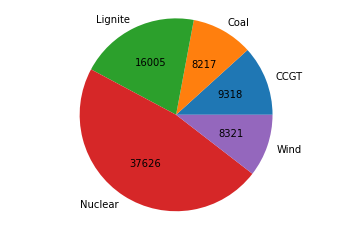

In [38]:
fig1, ax1 = plt.subplots()

ax1.pie(sizes,labels=labels, autopct=lambda p: '{:.0f}'.format(p * total / 100)) # autopct is used for automatic labelling, no need to understand all coding details here
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

### 5.2 Create line chart of dispatched power

In [39]:
dispatch_g = {g: [] for g in G}
for t in T:
    for g in G:
        dispatch_g[g].append(pyomo.value(model.x_g_t[g,t]))

Text(0, 0.5, 'Dispatched Power [MW]')

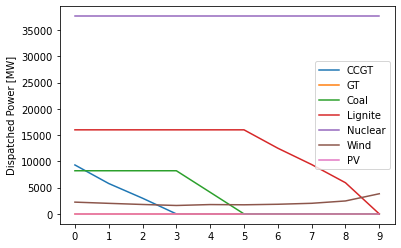

In [40]:
fig2, ax2 = plt.subplots()

for g in G:
    ax2.plot(T, dispatch_g[g])
ax2.legend(G)
ax2.xaxis.set_ticks(T)
ax2.set_ylabel('Dispatched Power [MW]')

### 5.3 Create line chart of electricity consumption

In [41]:
load_t_new = []
for t in T:
    temp_load = 0.0
    for g in G:
        temp_load += dispatch_g[g][t]
    load_t_new.append(temp_load)

Text(0, 0.5, 'Electricity Consumption [MWh]')

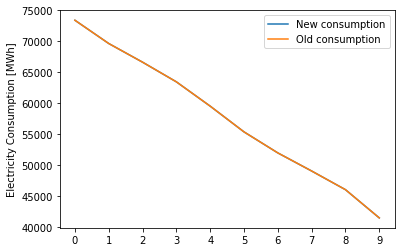

In [42]:
fig2, ax2 = plt.subplots()

ax2.plot(T, load_t_new)
ax2.plot(T, load_t)
ax2.legend(["New consumption", "Old consumption"])
ax2.xaxis.set_ticks(T)
ax2.set_ylabel('Electricity Consumption [MWh]')

### 5.4 Create line chart of energy consumption

In [43]:
fuel_name_translation_dict = {
    'CCGT': 'Gas',
    'GT': 'Gas',
    'Coal': 'Hard coal',
    'Lignite': 'Lignite',
    'Nuclear': 'Uranium',
    'diesel': 'Mineral oil',
    'gasoline': 'Mineral oil',
    'gas': 'Gas',
}

cons_vehicle_fuel_t = {key: [0.0 for _ in range(10)] for key in set(fuel_name_translation_dict.values())}

dispatch_g = {g: [] for g in G}
for t in T:
    for g in G:
        if g in fuel_name_translation_dict:
            key = fuel_name_translation_dict[g]
            cons_vehicle_fuel_t[key][t] += pyomo.value(model.x_g_t[g,t]/tech_data_g[(g,'eta_el')])

for t in T:
    for v in V:
        if v in fuel_name_translation_dict:
            key = fuel_name_translation_dict[v]
            cons_vehicle_fuel_t[key][t] += pyomo.value(model.y_v[v] * vehicle_data_v[(v,'eta_final_to_service')] / 100000 * vehicle_pas_car_t[t])

Text(0, 0.5, 'Energy Carrier Consumption [MWh]')

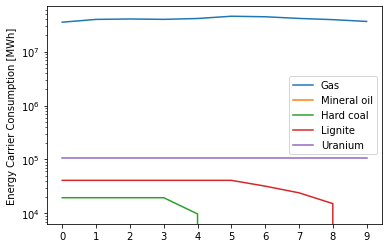

In [44]:
fig2, ax2 = plt.subplots()

for key in cons_vehicle_fuel_t:
    ax2.plot(T, cons_vehicle_fuel_t[key])
ax2.legend(cons_vehicle_fuel_t.keys())
ax2.xaxis.set_ticks(T)
ax2.set_yscale('log')
# ax2.set_ylim(bottom=1)
ax2.set_ylabel('Energy Carrier Consumption [MWh]')